# MILP Based Scheduler for Gravittaional Waves event follow-up for ZTF

## imports
Make sure to have CPLEX installed. Follow https://mertbakir.gitlab.io/operations-research/how-to-install-cplex-ibm-academic-initiative/ for installation guidelines for academic lisence.
Use requirements.txt to install all the packages.

In [34]:
import astroplan
import regions
from astropy.coordinates import ICRS, SkyCoord, AltAz, get_moon, EarthLocation, get_body
from astropy import units as u
from astropy.utils.data import download_file
from astropy.table import Table, QTable, join
from astropy.time import Time, TimeDelta
from astropy_healpix import *
from ligo.skymap import plot
from ligo.skymap.io import read_sky_map
import healpy as hp
import os
from matplotlib import pyplot as plt
from fractions import Fraction
import numpy as np
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import numpy as np
from tqdm.auto import tqdm
import datetime as dt
import pickle
import pandas as pd
from docplex.mp.model import Model
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
warnings.simplefilter('ignore', astroplan.TargetNeverUpWarning)
warnings.simplefilter('ignore', astroplan.TargetAlwaysUpWarning)

## Problem Setup

### Focal Plane Footprint

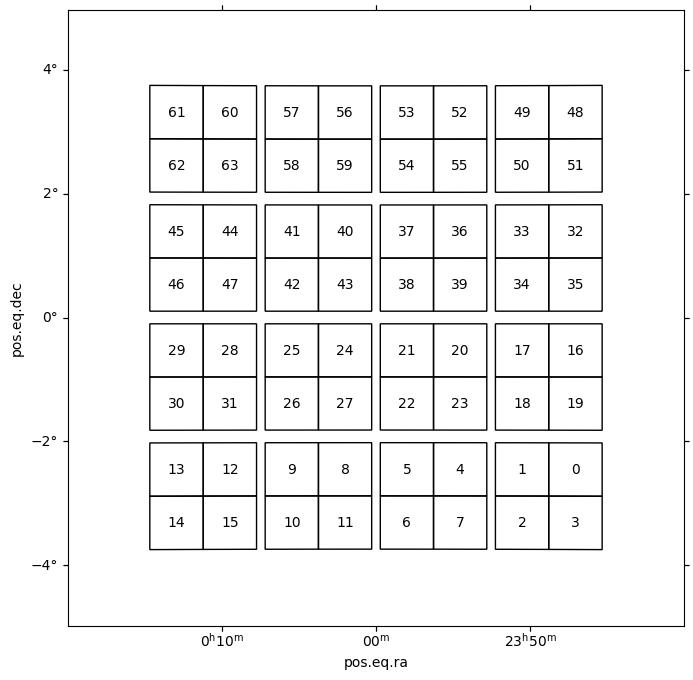

In [35]:
# Table 1 from Bellm et al. (2019)
# http://adsabs.harvard.edu/abs/2019PASP..131a8002B
ns_nchips = 4
ew_nchips = 4
ns_npix = 6144
ew_npix = 6160
plate_scale = 1.01 * u.arcsec
ns_chip_gap = 0.205 * u.deg
ew_chip_gap = 0.140 * u.deg

ns_total = ns_nchips * ns_npix * plate_scale + (ns_nchips - 1) * ns_chip_gap
ew_total = ew_nchips * ew_npix * plate_scale + (ew_nchips - 1) * ew_chip_gap

rcid = np.arange(64)

chipid, rc_in_chip_id = np.divmod(rcid, 4)
ns_chip_index, ew_chip_index = np.divmod(chipid, ew_nchips)
ns_rc_in_chip_index = np.where(rc_in_chip_id <= 1, 1, 0)
ew_rc_in_chip_index = np.where((rc_in_chip_id == 0) | (rc_in_chip_id == 3), 0, 1)

ew_offsets = ew_chip_gap * (ew_chip_index - (ew_nchips - 1) / 2) + ew_npix * plate_scale * (ew_chip_index - ew_nchips / 2) + 0.5 * ew_rc_in_chip_index * plate_scale * ew_npix
ns_offsets = ns_chip_gap * (ns_chip_index - (ns_nchips - 1) / 2) + ns_npix * plate_scale * (ns_chip_index - ns_nchips / 2) + 0.5 * ns_rc_in_chip_index * plate_scale * ns_npix

ew_ccd_corners = 0.5 * plate_scale * np.asarray([ew_npix, 0, 0, ew_npix])
ns_ccd_corners = 0.5 * plate_scale * np.asarray([ns_npix, ns_npix, 0, 0])

ew_vertices = ew_offsets[:, np.newaxis] + ew_ccd_corners[np.newaxis, :]
ns_vertices = ns_offsets[:, np.newaxis] + ns_ccd_corners[np.newaxis, :]


def get_footprint(center):
    dx, dy, x0, y0 = np.broadcast_arrays(ew_vertices.to_value(u.deg), ns_vertices.to_value(u.deg), center[..., np.newaxis, np.newaxis].icrs.ra.deg, center[..., np.newaxis, np.newaxis].icrs.dec.deg)
    return SkyCoord(dx*u.deg, dy*u.deg, frame=SkyCoord(x0*u.deg, y0*u.deg).skyoffset_frame()).icrs

def list_to_grid(f_list, f_grid):
    grid_list = []

    for f in f_list:
        grid_list.append(f_grid[f_grid['field_id'] == f])
    
    return grid_list

center = SkyCoord(0 * u.deg, 0 * u.deg)
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='astro zoom', center='0d 0d', radius=5 * u.deg)
for i, verts in enumerate(get_footprint(center)):
    rc_center = SkyCoord(*verts.cartesian.xyz.sum(1), representation_type='cartesian')
    rc_center.representation_type = 'unitspherical'
    ax.add_patch(plt.Polygon(np.column_stack((verts.ra.deg, verts.dec.deg)), edgecolor='k', facecolor='none', transform=ax.get_transform('world')))
    ax.text(rc_center.ra.deg, rc_center.dec.deg, str(i), transform=ax.get_transform('world'), ha='center', va='center')

### load the field list from ZTF

In [36]:
url = 'https://github.com/ZwickyTransientFacility/ztf_information/raw/master/field_grid/ZTF_Fields.txt'
filename = download_file(url)
field_grid = QTable(np.recfromtxt(filename, comments='%', usecols=range(3), names=['field_id', 'ra', 'dec']))
field_grid['coord'] = SkyCoord(field_grid.columns.pop('ra') * u.deg, field_grid.columns.pop('dec') * u.deg)
field_grid = field_grid[0:881]
# np.save(filename)
print(field_grid)

field_id      coord      
             deg,deg     
-------- ----------------
       1       0.0,-89.05
       2      90.0,-89.05
       3     180.0,-89.05
       4     270.0,-89.05
       5  16.36364,-81.85
       6  49.09091,-81.85
       7  81.81818,-81.85
       8 114.54545,-81.85
       9 147.27273,-81.85
     ...              ...
     872      140.0,83.75
     873      180.0,83.75
     874      220.0,83.75
     875      260.0,83.75
     876      300.0,83.75
     877      340.0,83.75
     878        10.0,88.0
     879       170.0,88.0
     880        10.0,87.4
     881       170.0,87.4
Length = 881 rows


### load the skymap
Change the directory address to new path 

In [37]:
directory_path = "/u/ywagh/test_skymaps/007.gz"
skymap, metadata = read_sky_map(os.path.join(directory_path))

### Observability Constraints

In [49]:
event_time = Time(metadata['gps_time'], format='gps').utc
gps_time = Time(metadata['gps_time'], format='gps')

event_time.format = 'iso'
print('event time:',event_time)
observer = astroplan.Observer.at_site('Palomar')
night_horizon = -18 * u.deg
if observer.is_night(event_time, horizon=night_horizon):
    start_time = event_time
else:
    start_time = observer.sun_set_time(
        event_time, horizon=night_horizon, which='next')

# Find the latest possible end time of observations: the time of sunrise.
end_time = observer.sun_rise_time(
    start_time, horizon=night_horizon, which='next')

min_airmass = 2.5 * u.dimensionless_unscaled
airmass_horizon = (90 * u.deg - np.arccos(1 / min_airmass))
targets = field_grid['coord']

# Find the time that each field rises and sets above an airmass of 2.5.
target_start_time = Time(np.where(
    observer.target_is_up(start_time, targets, horizon=airmass_horizon),
    start_time,
    observer.target_rise_time(start_time, targets, which='next', horizon=airmass_horizon)))
target_start_time.format = 'iso'

# Find the time that each field sets below the airmass limit. If the target
# is always up (i.e., it's circumpolar) or if it sets after surnsise,
# then set the end time to sunrise.
target_end_time = observer.target_set_time(
    target_start_time, targets, which='next', horizon=airmass_horizon)
target_end_time[
    (target_end_time.mask & ~target_start_time.mask) | (target_end_time > end_time)
] = end_time
target_end_time.format = 'iso'
# Select fields that are observable for long enough for at least one exposure
##############################################################################
exposure_time = 180 * u.second
exposure_time_day = exposure_time.to_value(u.day)

num_visits = 3
num_filters = 1

cadence = 30         #minutes
cadence_days = cadence / (60 * 24)
##############################################################################
field_grid['start_time'] = target_start_time
field_grid['end_time'] = target_end_time
observable_fields = field_grid[target_end_time - target_start_time >= exposure_time]

# print(observable_fields)
hpx = HEALPix(nside=256, frame=ICRS())

footprint = np.moveaxis(
    get_footprint(SkyCoord(0 * u.deg, 0 * u.deg)).cartesian.xyz.value, 0, -1)
footprint_healpix = np.unique(np.concatenate(
    [hp.query_polygon(hpx.nside, v, nest=(hpx.order == 'nested')) for v in footprint]))

'''
# computing the footprints of every ZTF field as HEALPix indices. Downsampling skymap to same resolution.
'''
footprints = np.moveaxis(get_footprint(observable_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints)]

prob = hp.ud_grade(skymap, hpx.nside, power=-2)

# k = max number of 300s exposures 
min_start = min(observable_fields['start_time'])
max_end =max(observable_fields['end_time'])
# min_start.format = 'jd'
# max_end.format = 'jd'

# k=15

k = int(np.floor((max_end - min_start)/(1.5*exposure_time.to(u.day))))
k = np.floor(k/(num_visits*num_filters))
print(k," number of exposures could be taken tonight")

print("problem setup completed")

event time: 2019-09-30 13:35:41.243


/u/ywagh/.local/lib/python3.10/site-packages/astropy/units/quantity.py:671: RuntimeWarning: invalid value encountered in divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


  0%|          | 0/525 [00:00<?, ?it/s]

41.0  number of exposures could be taken tonight
problem setup completed


### Plotting the skymap

The center can be shifted to get the better view of the localization

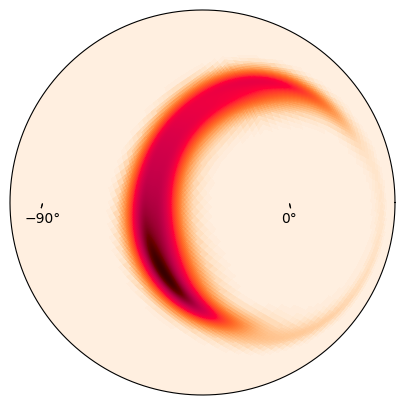

In [39]:
plt.figure(figsize=(6, 5))
# shift the center to origin for normal view
# ax = plt.axes(projection='astro mollweide', center='0h 0d')

ax = plt.axes(projection='geo globe', center='22h 30d')
ax.imshow_hpx(prob, cmap='cylon')

## Model 1: Maximum Weighted Coverage Problem

In [50]:
m1 = Model('max coverage problem')

field_vars = m1.binary_var_list(len(footprints), name='field')
pixel_vars = m1.binary_var_list(hpx.npix, name='pixel')

footprints_healpix_inverse = [[] for _ in range(hpx.npix)]

for field, pixels in enumerate(footprints_healpix):
    for pixel in pixels:
        footprints_healpix_inverse[pixel].append(field)

for i_pixel, i_fields in enumerate(footprints_healpix_inverse):
    m1.add_constraint(m1.sum(field_vars[i] for i in i_fields) >= pixel_vars[i_pixel])

m1.add_constraint(m1.sum(field_vars) <= k)
m1.maximize(m1.dot(pixel_vars, prob))
print(f"number fo fields observed should be less than {k}")

solution = m1.solve(log_output=True)
print("optimization completed")

total_prob_covered = solution.objective_value
print("Total probability covered:",total_prob_covered)

number fo fields observed should be less than 41.0
Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 0.000000 after 0.02 sec. (24.20 ticks)
Tried aggregator 3 times.
MIP Presolve eliminated 785009 rows and 616387 columns.
Aggregator did 263 substitutions.
Reduced MIP has 1161 rows, 1422 columns, and 4321 nonzeros.
Reduced MIP has 1422 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.70 sec. (738.31 ticks)
Probing time = 0.00 sec. (0.29 ticks)
Tried aggregator 1 time.
Detecting symmetries...
Reduced MIP has 1161 rows, 1422 columns, and 4321 nonzeros.
Reduced MIP has 1422 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (2.80 ticks)
Probing time = 0.00 sec. (0.29 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mode: deterministic, using up to 32 threads.
Root relaxation solution time = 0.00 sec. (2.40 ticks)

      

### Extracting the selected fields

In [51]:
selected_fields_ID = [i for i, v in enumerate(field_vars) if v.solution_value == 1]
print(len(selected_fields_ID), "fields selected")
selected_fields = observable_fields[selected_fields_ID]
print(selected_fields)

41 fields selected
field_id      coord             start_time               end_time       
             deg,deg                                                    
-------- --------------- ----------------------- -----------------------
     391 329.95489,-9.85 2019-10-01 02:55:44.324 2019-10-01 08:41:54.762
     392 337.00407,-9.85 2019-10-01 02:55:44.324 2019-10-01 09:10:02.637
     441 319.53365,-2.65 2019-10-01 02:55:44.324 2019-10-01 08:25:07.204
     442  326.5625,-2.65 2019-10-01 02:55:44.324 2019-10-01 08:53:11.194
     443 333.59135,-2.65 2019-10-01 02:55:44.324 2019-10-01 09:21:14.459
     492  316.16296,4.55 2019-10-01 02:55:44.324 2019-10-01 08:32:47.312
     493  323.17384,4.55 2019-10-01 02:55:44.324 2019-10-01 09:00:46.940
     494  330.18472,4.55 2019-10-01 02:55:44.324 2019-10-01 09:28:46.393
     543 312.88387,11.75 2019-10-01 02:55:44.324 2019-10-01 08:38:27.642
     ...             ...                     ...                     ...
     803 335.18412,54.95 2019-10

### Calculating matrix for slew time
mention the assumption behind using this formulation

In [52]:
separation_matrix = selected_fields['coord'][:,np.newaxis].separation(selected_fields['coord'][np.newaxis,:])

# these are the parameters related to the telescope
slew_speed = 2.5 * u.deg / u.s
slew_accel = 0.4 * u.deg / u.s**2
readout = 8.2 * u.s

def slew_time(separation):
   return np.where(separation <= (slew_speed**2 / slew_accel),
                   np.sqrt(2 * separation / slew_accel),
                   (2 * slew_speed / slew_accel) + (separation - slew_speed**2 / slew_accel) / slew_speed)

slew_times = slew_time(separation_matrix).value

slew_time_value = slew_times*u.second
slew_time_day = slew_time_value.to_value(u.day)

### Calculating Probability Covered for individual fields

In [53]:
footprints_selected = np.moveaxis(get_footprint(selected_fields['coord']).cartesian.xyz.value, 0, -1)
footprints_healpix_selected = [
    np.unique(np.concatenate([hp.query_polygon(hpx.nside, v) for v in footprint]))
    for footprint in tqdm(footprints_selected)]

probabilities = []

for field_index in range(len(footprints_healpix_selected)):
    probability_field = np.sum(prob[footprints_healpix_selected[field_index]])
    probabilities.append(probability_field)
print("worked for",len(probabilities),"fields")

selected_fields['probabilities'] = probabilities

  0%|          | 0/41 [00:00<?, ?it/s]

worked for 41 fields


### Plotting the seleccted fields

The center can be shifted to get the better view of the localization

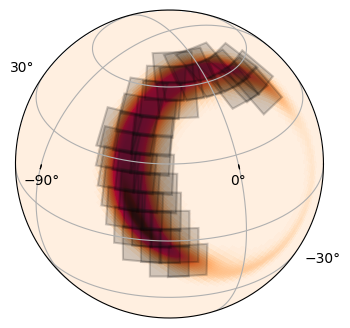

In [54]:
plt.figure(figsize=(8, 4))
#off-center case
# ax = plt.axes(projection='astro mollweide', center='0h 60d')
ax = plt.axes(projection='geo globe', center='22h 30d')

for row in selected_fields:
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs
    ax.add_patch(plt.Polygon(
    np.column_stack((coords.ra.deg, coords.dec.deg)),
    facecolor=(0.1, 0.1, 0.1),  # Light gray fill
    edgecolor='black',      # Dark black edge
    linewidth=1.5,          # Increase edge thickness for contrast
    alpha=0.2,              # Apply transparency to facecolor only
    transform=ax.get_transform('world')
))
ax.grid()
ax.imshow_hpx(prob, cmap='cylon')
# plt.text(0.05, 0.95, f'Total Probability Covered: {total_prob_covered:.2f}', transform=ax.transAxes,
#         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

## Filtering fields that are available for multiple visits

In [55]:
delta = exposure_time.to_value(u.day)

limit_duration = ((end_time-start_time).value*2/3) 
filtered_rows = [
    row for row in selected_fields
    if (row['end_time'] - row['start_time']).to_value(u.day) > limit_duration
]
selected_fil_fileds = QTable(rows=filtered_rows, names=selected_fields.colnames)
print(f"{len(selected_fil_fileds)} fields available for the observation throughout the night")

29 fields available for the observation throughout the night


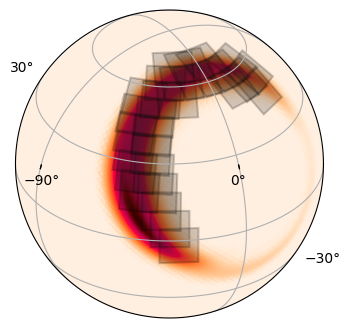

In [56]:
plt.figure(figsize=(6, 4))
#off-center case
# ax = plt.axes(projection='astro mollweide', center='0h 60d')
ax = plt.axes(projection='geo globe', center='22h 30d')

for row in selected_fil_fileds:
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs
    ax.add_patch(plt.Polygon(
    np.column_stack((coords.ra.deg, coords.dec.deg)),
    facecolor=(0.1, 0.1, 0.1),  # Light gray fill
    edgecolor='black',      # Dark black edge
    linewidth=1.5,          # Increase edge thickness for contrast
    alpha=0.2,              # Apply transparency to facecolor only
    transform=ax.get_transform('world')
))
ax.grid()
ax.imshow_hpx(prob, cmap='cylon')
# plt.text(0.05, 0.95, f'Total Probability Covered: {total_prob_covered:.2f}', transform=ax.transAxes,
#         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))

## Model 2: The scheduling algorithm

In [57]:
m2 = Model("Telescope timings")

delta = exposure_time.to_value(u.day)
M = (selected_fil_fileds['end_time'].max() - selected_fil_fileds['start_time'].min()).to_value(u.day).item()

x = [[m2.binary_var(name=f"x_{i}_visit_{v}") 
      for v in range(num_visits*num_filters)] 
      for i in range(len(selected_fil_fileds))]

tc = [[m2.continuous_var(
    lb=(row['start_time'] - start_time).to_value(u.day),
    ub=(row['end_time'] - start_time - exposure_time).to_value(u.day),
    name=f"start_time_field_{i}_visit_{v}")
    for v in range(num_visits*num_filters)] 
    for i, row in enumerate(selected_fil_fileds)]

visit_transition_times = [m2.continuous_var(
    lb=0,ub=M,name=f"visit_transition_{v}")
                          for v in range(num_visits*num_filters-1)]  

# Isolating visits
for v in range(1, num_visits*num_filters):
    for i in range(len(selected_fil_fileds)):
        m2.add_constraint(tc[i][v-1] + delta * x[i][v-1] <= visit_transition_times[v-1],
            ctname=f"visit_end_{i}_visit_{v-1}")
        m2.add_constraint(tc[i][v] >= visit_transition_times[v-1],
            ctname=f"visit_start_{i}_visit_{v}")


# Cadence constraints
for i in range(len(selected_fil_fileds)):
    for v in range(1, num_visits*num_filters):
        m2.add_constraint(tc[i][v] - tc[i][v-1] >= (cadence_days+delta) * (x[i][v] + x[i][v-1] - 1),
            ctname=f"cadence_constraint_field_{i}_visits_{v}")

#non-overlapping
for v in range(num_visits*num_filters):
    for i in range(len(selected_fil_fileds)):
        for j in range(i):
            m2.add_constraint(tc[i][v] + delta * x[i][v] + slew_time_day[i][j] - tc[j][v] <= M * (2 - x[i][v] - x[j][v]),
                              ctname=f"non_overlapping_cross_fields_{i}_{j}_visits_{v}")
            m2.add_constraint(tc[j][v] + delta * x[j][v] + slew_time_day[i][j] - tc[i][v] <= M * (-1 + x[i][v] + x[j][v]),
                ctname=f"non_overlapping_cross_fields_{j}_{i}_visits_{v}")

# Initialize the objective
m2.maximize(
    m2.sum(probabilities[i] * x[i][v]
           for i in range(len(selected_fil_fileds))
           for v in range(num_visits*num_filters))
)

# m2.parameters.timelimit = 60
# m2.parameters.mip.tolerances.mipgap = 0.01  # 1% optimality gap
# m2.parameters.emphasis.mip = 2  # Emphasize optimality over feasibility
solution = m2.solve(log_output=True)

Version identifier: 22.1.1.0 | 2022-11-28 | 9160aff4d
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIP Presolve modified 8378 coefficients.
Reduced MIP has 2610 rows, 176 columns, and 10266 nonzeros.
Reduced MIP has 87 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.01 sec. (6.45 ticks)
Found incumbent of value 1.856330 after 0.02 sec. (10.77 ticks)
Probing fixed 81 vars, tightened 5598 bounds.
Probing time = 0.03 sec. (39.79 ticks)
Tried aggregator 1 time.
MIP Presolve eliminated 1053 rows and 81 columns.
MIP Presolve modified 552 coefficients.
Reduced MIP has 1557 rows, 95 columns, and 3462 nonzeros.
Reduced MIP has 6 binaries, 0 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (2.49 ticks)
Probing fixed 0 vars, tightened 156 bounds.
Probing time = 0.00 sec. (0.82 ticks)
Tried aggregator 1 time.
Detecting symmetries...
MIP Presolve modified 552 coefficients.
Reduced MIP has 1557 rows, 95 columns, and 3462 nonzeros.
Reduced

### Extracting the scheduled fields

In [58]:

scheduled_fields_by_visit = []
for v in range(num_visits * num_filters):
    visit_fields = [i for i in range(len(selected_fil_fileds)) if solution.get_value(x[i][v]) == 1]
    scheduled_fields_by_visit.append(visit_fields)

scheduled_fields = selected_fil_fileds.copy()

scheduled_tc = []
for v in range(num_visits * num_filters):
    visit_times = []
    for i in range(len(selected_fil_fileds)):
        if i in scheduled_fields_by_visit[v]:
            visit_times.append(solution.get_value(tc[i][v]))
        else:
            visit_times.append(np.nan) 
    scheduled_tc.append(visit_times)

scheduled_tc = np.array(scheduled_tc).T  

for i in range(num_visits * num_filters):
    scheduled_fields[f"Scheduled_start_filt_times_{i}"] = scheduled_tc[:, i]

for v in range(num_visits * num_filters):
    scheduled_fields[f"Selected_in_visit_{v}"] = [1 if i in scheduled_fields_by_visit[v] else 0 
                                                 for i in range(len(scheduled_fields))]

### plotting scheduled fields for a single visit

/tmp/ipykernel_3121712/3330939185.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('pink')  # Use binary colormap


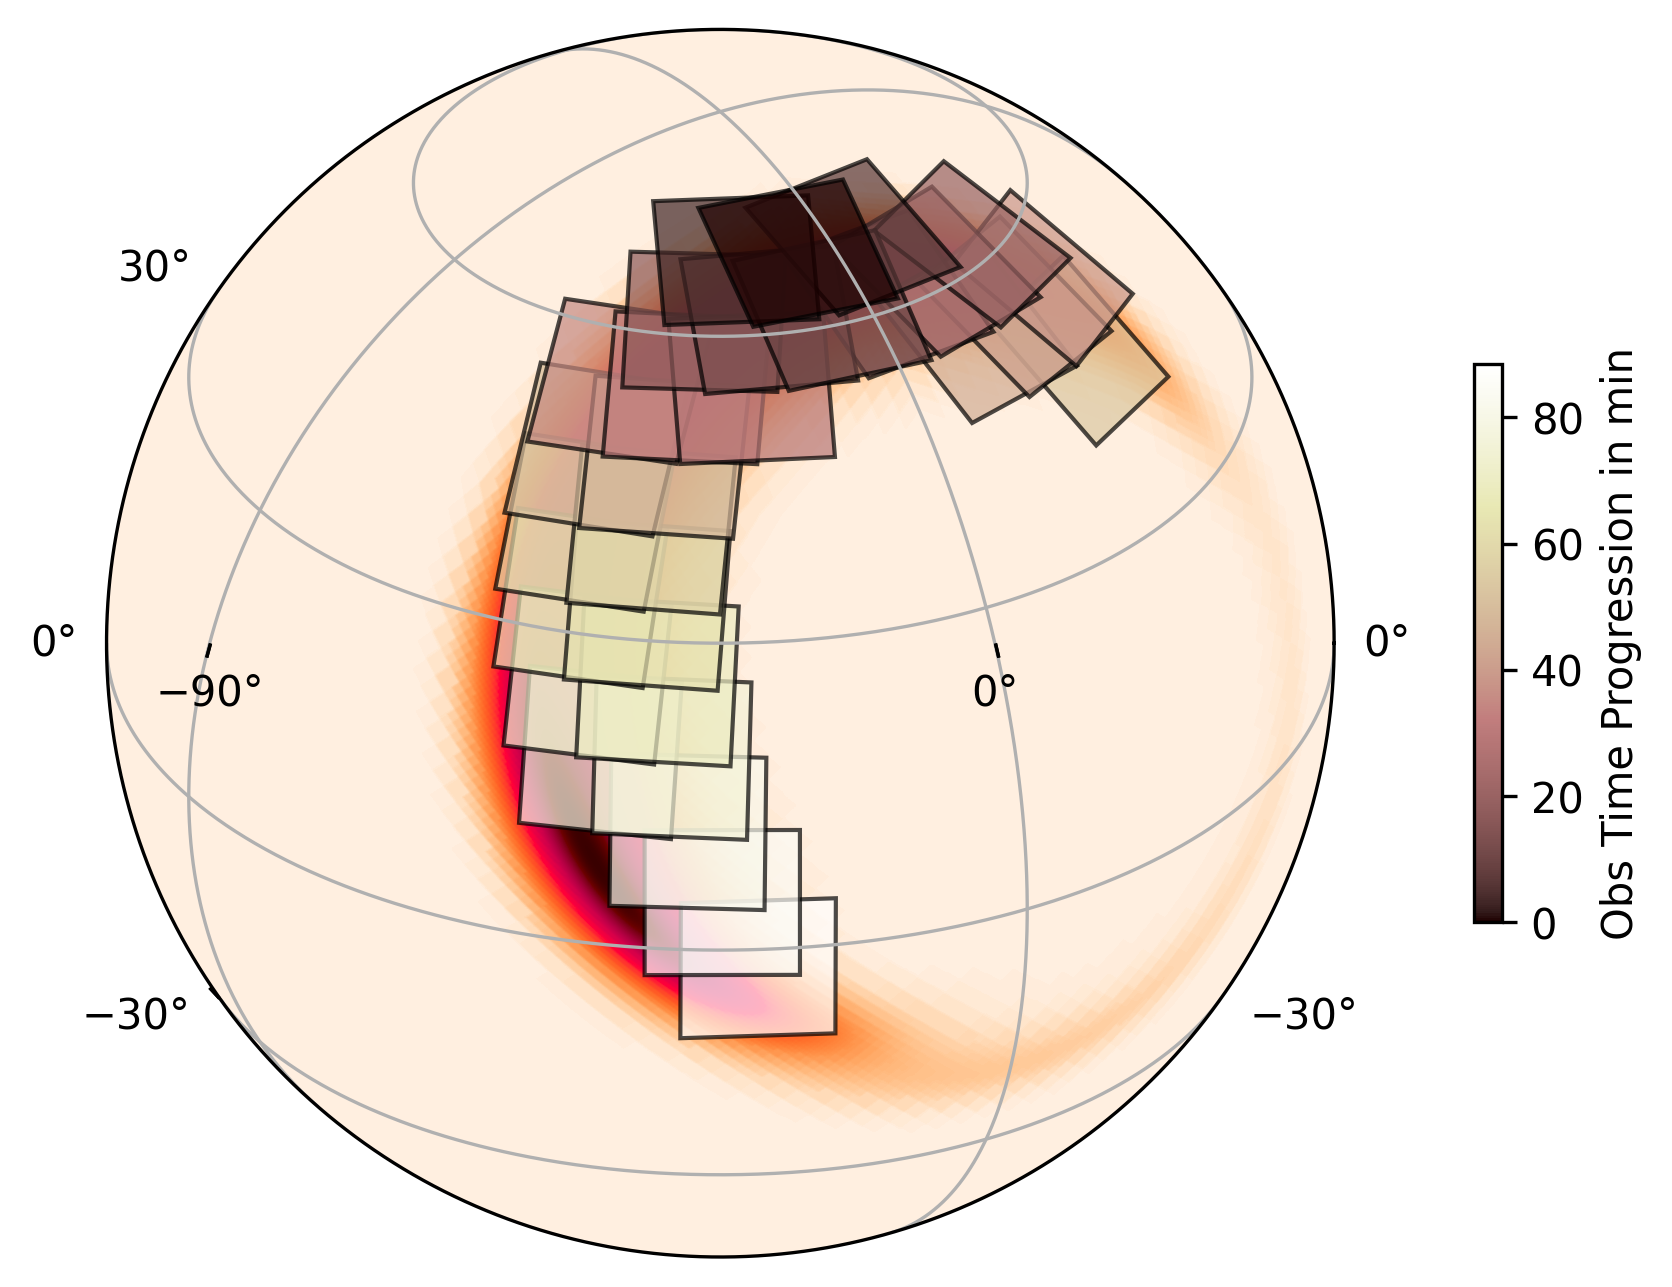

In [61]:
# Convert start times to numeric values
start_times = scheduled_tc[:, 0] * 24 *60 # Extract first column (start times)
min_time = min(start_times)
time_diffs = np.array(start_times) - min_time  # Time differences from the earliest tile

norm = mcolors.Normalize(vmin=min(time_diffs), vmax=max(time_diffs))
cmap = cm.get_cmap('pink')  # Use binary colormap

plt.figure(figsize=(6, 6),dpi = 300)
ax = plt.axes(projection='geo globe', center='22h 30d')

for row, time_diff in zip(selected_fil_fileds, time_diffs):
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs

    color = cmap(norm(time_diff))  # Get color based on time difference

    ax.add_patch(plt.Polygon(
        np.column_stack((coords.ra.deg, coords.dec.deg)),
        alpha=0.7,
        facecolor=color,
        edgecolor='black',
        transform=ax.get_transform('world')
    ))

ax.grid()
ax.imshow_hpx(prob, cmap='cylon')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, label="Obs Time Progression in min",fraction=0.02, pad=0.1)
plt.show()


### plotting multiple visits

/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 4 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 4 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 4 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "taiutc" yielded 4 of "dubious year (Note 4)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/u/ywagh/.local/lib/python3.10/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 4 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}'

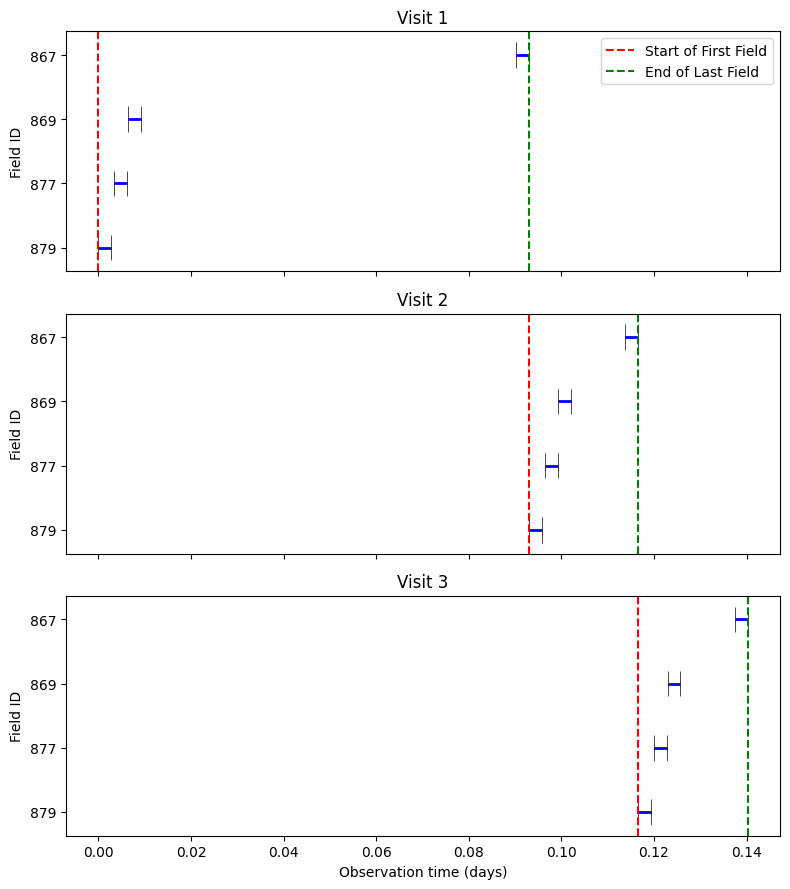

In [32]:
n_visits = num_visits * num_filters  

fig, axes = plt.subplots(n_visits, 1, figsize=(8, 3 * n_visits), sharex=True)

for i in range(n_visits):
    start_col = f'Scheduled_start_filt_times_{i}'
    end_col = f'Scheduled_end_filt_times_{i}'
    
    # Filter valid rows
    valid_rows = ~np.isnan(scheduled_tc).any(axis=1)
    valid_scheduled_tc = scheduled_tc[valid_rows]
    valid_scheduled_fields = scheduled_fields[valid_rows]
    
    if len(valid_scheduled_fields) == 0:
        print(f"No entries found for Visit {i + 1}. Skipping plot.")
        continue  # Skip this visit
    
    # Convert start times to ISO format and compute end times
    valid_scheduled_fields[start_col] = Time(valid_scheduled_fields[start_col], format='mjd')
    valid_scheduled_fields[start_col].format = 'iso'
    valid_scheduled_fields[end_col] = valid_scheduled_fields[start_col] + exposure_time_day
    
    # Sort fields by end time
    valid_scheduled_fields.sort(end_col)
    
    # Get the start and end times for plotting
    first_start_time = valid_scheduled_fields[start_col].mjd[0]
    last_end_time = valid_scheduled_fields[end_col].mjd[-1]
    
    ax = axes[i]
    ax.hlines(
        np.arange(len(valid_scheduled_fields)),
        valid_scheduled_fields[start_col].mjd,
        valid_scheduled_fields[end_col].mjd,
        colors='blue',
        linewidth=2
    )
    # Plot small vertical lines at start and end times of each interval
    for j in range(len(valid_scheduled_fields)):
        ax.vlines(
            valid_scheduled_fields[start_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
        ax.vlines(
            valid_scheduled_fields[end_col][j].mjd,
            ymin=j - 0.2,
            ymax=j + 0.2,
            color='black',
            linewidth=0.5,
            linestyle='-'
        )
    
    # Highlight first start and last end times
    if i == 0:  # Add legend only for the first subplot
        ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5, label='Start of First Field')
        ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5, label='End of Last Field')
        ax.legend(loc='upper right')
    else:
        ax.axvline(first_start_time, color='red', linestyle='--', linewidth=1.5)
        ax.axvline(last_end_time, color='green', linestyle='--', linewidth=1.5)
    
    # Add labels and title
    ax.set_yticks(np.arange(len(valid_scheduled_fields)))
    ax.set_yticklabels(valid_scheduled_fields['field_id'].astype(str))
    ax.set_ylabel('Field ID')
    ax.set_title(f'Visit {i + 1}')
    
axes[-1].set_xlabel('Observation time (days)')

plt.tight_layout()
# save_path = '/u/ywagh/scheduler_results/plots_manuscript'
# os.makedirs(save_path, exist_ok=True)  # Ensure directory exists
# full_path = os.path.join(save_path, f'schedule_revisit_.png')
# plt.savefig(full_path, dpi=300, bbox_inches='tight')
plt.show()


## Misceleneous

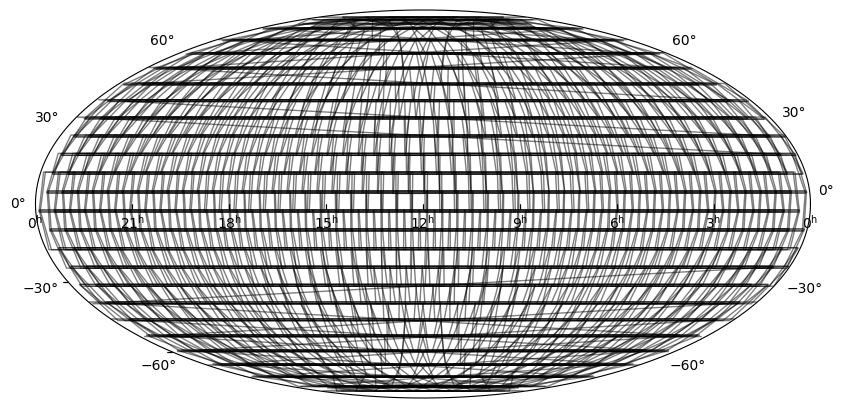

In [5]:
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='astro mollweide')
for row in field_grid:
    coords = SkyCoord(
        [ew_total, -ew_total, -ew_total, ew_total],
        [ns_total, ns_total, -ns_total, -ns_total],
        frame=row['coord'].skyoffset_frame()
    ).icrs
    ax.add_patch(plt.Polygon(
        np.column_stack((coords.ra.deg, coords.dec.deg)),
        alpha=0.5,
        facecolor='none',
        edgecolor='black',
        transform=ax.get_transform('world')
    ))